In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')

Index([u'2000', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011',
       u'2012', u'2013', u'2014', u'2015', u'2016'],
      dtype='object')

In [27]:
rent_increases = pd.DataFrame(index = median_rents.index, columns=['Sub-Borough Area'])
rent_increases['Sub-Borough Area'] = median_rents['Sub-Borough Area']
years = median_rents.columns[4:]
for idx, col in enumerate(years):
    if idx > 0:
        neighborhood_percentage_increase = (median_rents[years[idx]] - median_rents[years[idx-1]]) / median_rents[years[idx-1]]
        nyc_percentage_increase = (nyc_median_rents[years[idx]] - nyc_median_rents[years[idx-1]]) / nyc_median_rents[years[idx-1]]
        rent_increases[years[idx]] = neighborhood_percentage_increase - nyc_percentage_increase[0]
rent_increases

,Sub-Borough Area,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Sunnyside/Woodside,-0.007812,0.046269,-0.071092,0.028312,0.020236,0.006054,0.012915,-0.008000,0.051533,-0.011899,-0.033788
1,Greenwich Village/Financial District,0.044776,0.019722,-0.017057,-0.580060,0.528926,-0.171529,0.054435,0.109647,-0.168546,1.030531,-0.071008
2,Highbridge/South Concourse,0.021505,0.033256,-0.016215,-0.034188,0.023471,-0.008130,-0.017680,0.069670,-0.068855,0.006728,-0.005947
3,North Shore,-0.017391,0.061947,-0.034580,-0.092521,0.080816,-0.072646,-0.042547,-0.025857,0.003463,0.013240,0.018861
4,Mott Haven/Hunts Point,0.158730,-0.022548,0.001462,0.019866,-0.029349,-0.008130,0.004922,0.081744,-0.047339,0.005137,0.089614
5,Soundview/Parkchester,0.020000,-0.038261,-0.006114,-0.004485,0.012317,0.047945,-0.070011,0.001434,0.013574,-0.012990,0.002662
6,Flushing/Whitestone,0.014706,-0.016096,-0.033615,-0.004776,0.019185,-0.028820,-0.029191,-0.008000,-0.023810,0.004963,0.033574
7,University Heights/Fordham,0.031579,0.001355,0.003987,-0.024384,0.041724,-0.063176,0.030770,-0.036037,0.014652,-0.003230,-0.006029
8,East New York/Starrett City,0.107527,0.010568,0.011779,-0.034188,0.010994,-0.017059,-0.062119,0.077714,-0.085213,0.006375,0.002980
9,South Ozone Park/Howard Beach,-0.014184,-0.037627,-0.004094,-0.063174,0.035710,-0.036499,-0.015364,-0.015353,0.020635,-0.016823,-0.008045


In [42]:
income_diffs = pd.DataFrame(index = median_incomes.index, columns=['Sub-Borough Area'])
income_diffs['Sub-Borough Area'] = median_incomes['Sub-Borough Area']
income_diffs['2005'] = median_incomes[year] - nyc_median_incomes['2005'][0]
low_income = income_diffs['2005'] < income_diffs['2005'].quantile(q=0.4)
income_diffs[low_income]['Sub-Borough Area']

1                    Soundview/Parkchester
4                             Borough Park
5               Highbridge/South Concourse
8                           Central Harlem
10                          Pelham Parkway
11                         Elmhurst/Corona
17                                Flatbush
19                      Morrisania/Belmont
20             East New York/Starrett City
22    Morningside Heights/Hamilton Heights
25                               Rockaways
27                     Flushing/Whitestone
29              University Heights/Fordham
32             Kingsbridge Heights/Moshulu
34                  Mott Haven/Hunts Point
36               Lower East Side/Chinatown
38                             East Harlem
40                  Brownsville/Ocean Hill
43                     South Crown Heights
46                             Bensonhurst
47                            Coney Island
52                                Bushwick
Name: Sub-Borough Area, dtype: object

In [43]:
rent_increases[low_income]

,Sub-Borough Area,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,Greenwich Village/Financial District,0.044776,0.019722,-0.017057,-0.580060,0.528926,-0.171529,0.054435,0.109647,-0.168546,1.030531,-0.071008
4,Mott Haven/Hunts Point,0.158730,-0.022548,0.001462,0.019866,-0.029349,-0.008130,0.004922,0.081744,-0.047339,0.005137,0.089614
5,Soundview/Parkchester,0.020000,-0.038261,-0.006114,-0.004485,0.012317,0.047945,-0.070011,0.001434,0.013574,-0.012990,0.002662
8,East New York/Starrett City,0.107527,0.010568,0.011779,-0.034188,0.010994,-0.017059,-0.062119,0.077714,-0.085213,0.006375,0.002980
10,Elmhurst/Corona,0.007812,-0.001098,-0.034008,0.027827,-0.023828,-0.000777,-0.008065,0.006599,-0.009421,-0.002639,-0.056417
11,Rego Park/Forest Hills,0.023077,0.043782,-0.033459,-0.026994,0.012043,0.019648,-0.041848,0.033958,-0.017098,0.008992,-0.008627
17,Flatbush,-0.026316,0.009168,-0.017466,-0.034188,0.027331,0.008677,-0.008065,0.000264,0.033568,0.000000,-0.022556
19,Flatlands/Canarsie,-0.048387,0.041998,-0.042445,-0.009598,-0.024529,-0.000066,-0.000065,0.039619,-0.054113,0.008055,0.007519
20,Jamaica,-0.026316,-0.008850,-0.017307,0.019383,0.008895,-0.024659,0.000339,0.008667,-0.023810,-0.022811,0.001223
22,Williamsburg/Greenpoint,-0.039216,0.144212,-0.052864,0.011267,-0.007833,0.112560,0.030397,-0.030222,0.195887,-0.024797,0.059036


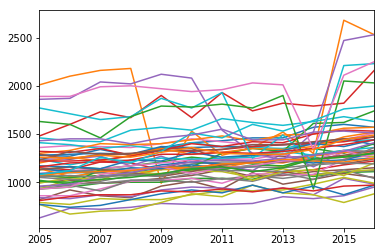

In [58]:
median_rents.set_index('Sub-Borough Area')[years].transpose().plot(legend=False)
plt.show()

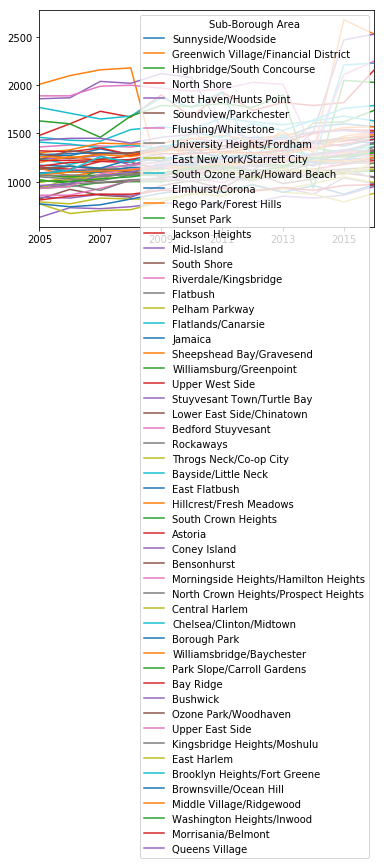

In [60]:
median_rents.set_index('Sub-Borough Area')[years].transpose().plot()
plt.show()